In [5]:
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [6]:
import torch
import torch.nn as nn
import torch.utils.data as torch_data

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
def compare_imgs(img_true, img_rec, verbose=True):

    assert img_true.shape == img_rec.shape
    if len(img_true.shape) == 3:
        assert img_true.shape[0] == 1

        img_true = img_true[0]
        img_rec = img_rec[0]

    img_true = img_true.numpy() if isinstance(img_true, torch.Tensor) else img_true
    img_rec = img_rec.numpy() if isinstance(img_rec, torch.Tensor) else img_rec

    mae = mean_absolute_error(img_true, img_rec)
    psnr = compare_psnr(img_true, img_rec)
    ssim = compare_ssim(img_true, img_rec)

    if verbose:
        print('\tMAE\tPSNR\tSSIM')
        print(f'score\t{mae:.3f}\t{psnr:.3f}\t{ssim:.3f}')

    return [mae, psnr, ssim]


def npy_load(path):
    with open(path, 'rb') as f:
        return np.load(f)



In [14]:
PATH_TO_SOURCE_TRAIN = 'data/ax_t2_single_source_train'
PATH_TO_SOURCE_TEST = 'data/ax_t2_single_source_test'
PATH_TO_SAMPLED_TRAIN = 'data/ax_t2_single_sampled_x2_train'
PATH_TO_SAMPLED_TEST = 'data/ax_t2_single_sampled_x2_test'

RANDOM_STATE = 42

In [25]:
class fastMRIData(torch_data.Dataset):
    def __init__(self, images, path_to_source, path_to_sampled):
        super().__init__()

        self.path_to_source = path_to_source
        self.path_to_sampled = path_to_sampled

        source_images = set(os.listdir(path_to_source))
        sampled_images = set(os.listdir(path_to_sampled))
        intersected_images = source_images.intersection(sampled_images)
        images = sorted([img for img in intersected_images if img.endswith('npy')])

        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        source_image = npy_load(os.path.join(self.path_to_source, self.images[idx]))
        sampled_image = npy_load(os.path.join(self.path_to_sampled, self.images[idx]))
        
        source_image = torch.from_numpy(source_image)
        sampled_image = torch.from_numpy(sampled_image)

        return source_image, sampled_image

In [27]:
fmri_train = fastMRIData(images, PATH_TO_SOURCE_TRAIN, PATH_TO_SAMPLED_TRAIN)
fmri_test = fastMRIData(images, PATH_TO_SOURCE_TEST, PATH_TO_SAMPLED_TEST)

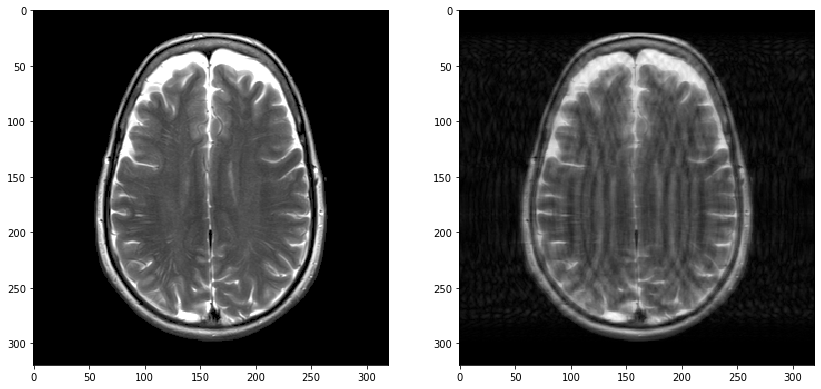

In [31]:
i = np.random.randint(0, len(fmri_train))
source, sampled = fmri_train.__getitem__(i)

fig, axis = plt.subplots(1, 2, figsize=(14, 12))
axis[0].imshow(source[0], cmap='gray', vmin=0, vmax=1)
axis[1].imshow(sampled[0], cmap='gray', vmin=0, vmax=1)
plt.show()

## Training

In [10]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,
          scheduler=None, verbose=True, save_dir=None):

    net.to(device)
    for epoch in range(1, epochs+1):

        net.train()
        for X, _ in train_loader:
            X = X.to(device)
            
            X_restored = net(X)
            loss = criterion(X, X_restored)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        net.eval()
        for X, _ in val_loader:

            X = X.to(device)

            X_restored = net(X)
            val_loss = criterion(X_restored, X)
            break

        if scheduler is not None:
            scheduler.step()

        freq = max(epochs//20, 1)
        if verbose and epoch%freq == 0:
            print('Epoch {}/{} \t|| LR: {:.5f} | Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs,
                                                                                  optimizer.param_groups[0]['lr'],
                                                                                  loss.item(), 
                                                                                  val_loss.item()))

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(RANDOM_STATE)

net = None
criterion = None
optimizer = None
scheduler = None

train_loader = torch_data.DataLoader(fmri_train, batch_size=1000, shuffle=True) 
test_loader = torch_data.DataLoader(fmri_test, batch_size=200, shuffle=False) 

In [39]:
%%time
for source, sampled in train_loader:
    print(source.shape, sampled.shape)
    break

torch.Size([1000, 1, 320, 320]) torch.Size([1000, 1, 320, 320])
CPU times: user 1.82 s, sys: 2.94 s, total: 4.76 s
Wall time: 22.4 s
